# Lane marking and signage intervention hypothesis test for I-40

In this notebook, we will perform a hypothesis test using counterfactual modeling to see if redoing the lane markings and signage (changing the category to 3 ='clear and visible') of the section of I-40 between the longitude range -88.373 to -88.286 will reduce the number of injurious crashes that occur.

#### 1. Package importing and data loading

During this step, we import our library dependencies and import our dataset which can be found here:

https://github.com/JamesOQ/Tuning-Up-Music-Highway/blob/main/datasets/rural%20I-40%20Madison%20and%20Henderson%20crashes.csv

In [92]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import pymc as pm
import arviz as az
import pytensor
pytensor.config.cxx = ""
from catboost import Pool
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


Our I-40 crash dataset was collected on May 23, 2025 at 11:04 AM CDT from the following Tennessee Department of Safety and Homeland Security dashboard of crashes that occured between 2023 and the above date:
https://www.tn.gov/safety/stats/dashboards/recent-crashes.html

We noticed that there were relatively high incidences of crashes on the stretch of I-40 between Madison and Henderson counties, so we decided to focus our analysis only on the stretch of I-40 in the longitude range –89.073096 to -88.198390. The crash data obtained from the dashboard only included 3 features: latitutde, longitude, and severity of crash. We transformed this dataset into something testable by manually recording the following geospatial features by longitude from Google Maps Streetview. The Google Map images were all taken between 2023-2025 and, since there were no major renovations on this stretch of Highway I-40 during that time, should be consistent with the features of our actual crash dataset.

##### Feature Classification Table

| **Feature**                                | **Value** | **Description**                                  |
|--------------------------------------------|-----------|--------------------------------------------------|
| **Presence of guardrails**                 | 0         | None                                             |
|                                            | 1         | One side only                                    |
|                                            | 2         | Both sides                                       |
|                                            | 3         | Partial or damaged                               |
| **Cable barriers**                         | 0         | None                                             |
|                                            | 1         | Median only                                      |
|                                            | 2         | Shoulder only                                    |
|                                            | 3         | Both median and shoulder                         |
| **Rumble strips**                          | 0         | None                                             |
|                                            | 1         | Centerline only                                  |
|                                            | 2         | Shoulder only                                    |
|                                            | 3         | Both centerline and shoulder                     |
| **Pavement condition**                     | 0         | Unknown                                          |
|                                            | 1         | Poor (cracks, potholes)                          |
|                                            | 2         | Fair                                             |
|                                            | 3         | Good                                             |
|                                            | 4         | Excellent (recently resurfaced)                 |
| **Proximity to highway entrances/exits**   | 0         | Not near entrance/exit                           |
|                                            | 1         | Near entrance/exit (≤ 400m)                      |
| **Urban vs. rural environment**            | 0         | Rural                                            |
|                                            | 1         | Suburban                                         |
|                                            | 2         | Urban                                            |
| **Surrounding natural features**           | 0         | Open/plain                                       |
|                                            | 1         | Forested/wooded                                  |
|                                            | 2         | Near water body                                  |
|                                            | 3         | Hilly/rocky                                      |
|                                            | 4         | Mixed or complex terrain                         |
| **Number of lanes**                        | 1         | One lane                                         |
|                                            | 2         | Two lanes                                        |
|                                            | 3         | 3–4 lanes                                        |
|                                            | 4         | 5+ lanes                                         |
| **Shoulder type and width**                | 0         | No shoulder                                      |
|                                            | 1         | Narrow, unpaved                                  |
|                                            | 2         | Narrow, paved                                    |
|                                            | 3         | Wide, unpaved                                    |
|                                            | 4         | Wide, paved                                      |
| **Posted speed limit**                     | 1         | ≤ 35 mph                                         |
|                                            | 2         | 40–55 mph                                        |
|                                            | 3         | 60–65 mph                                        |
|                                            | 4         | 70+ mph                                          |
| **Presence/type of median or divider**     | 0         | None                                             |
|                                            | 1         | Painted median                                   |
|                                            | 2         | Grass median                                     |
|                                            | 3         | Raised concrete divider                          |
|                                            | 4         | Guardrail or cable divider                       |
| **Lane markings/signage visibility**       | 0         | Missing or faded                                 |
|                                            | 1         | Poor                                             |
|                                            | 2         | Average                                          |
|                                            | 3         | Clear and visible                                |
|                                            | 4         | Fresh or high-reflectivity                       |
| **Nighttime lighting and visibility**      | 0         | No lighting                                      |
|                                            | 1         | Poor (e.g., sparse or non-functional)            |
|                                            | 2         | Moderate                                         |
|                                            | 3         | Well-lit                                         |


This can be found on the following google sheet: https://docs.google.com/spreadsheets/d/1zOUgfIgm1ztMX9Kwp7bK6PvghsTIMg_krHt-7JgNFRs/edit?usp=sharing

We ran a program which updated our crash dataset to include the above features. Finally, we noticed that there was a rather large discrepancy between urban and rural crashes in our exploratory data analysis, so we removed the urban crashes (those occuring in the city of Jackson, Tennessee) to focus only on rural safety interventions since the rural segments typically had a higher crash severity rate.













































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [97]:
df = pd.read_csv("rural I-40 Madison and Henderson crashes.csv")

#### 2. Intervention segment selection

The following code creates a map which displays all of the crashes in our rural crash dataset.

In [99]:
# Drop rows missing geolocation or crash type
df = df[df["Longitude"].notnull() & df["Latitude"].notnull() & df["Crash Type"].notnull()]

# Define color scheme for crash types
def get_color(crash_type):
    crash_type = crash_type.lower()
    if "fatal" in crash_type:
        return "darkred"
    elif "serious injury" in crash_type:
        return "orange"
    elif "injury" in crash_type:
        return "blue"
    else:
        return "gray"

# Create base map centered on the middle of the region
mid_lat = df["Latitude"].mean()
mid_lon = df["Longitude"].mean()
m = folium.Map(location=[mid_lat, mid_lon], zoom_start=11)

# Add crash points to the map using marker clustering
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    color = get_color(row["Crash Type"])
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=row["Crash Type"]
    ).add_to(marker_cluster)

# Display map in output
display(m)

The following code creates a map which displays only the injurious crashes

In [101]:
# Define a function to determine if a crash is injurious
def is_injurious(crash_type):
    if not isinstance(crash_type, str):
        return False
    crash_type = crash_type.lower()
    return "injury" in crash_type or "fatal" in crash_type or "serious injury" in crash_type

# Filter to only injurious crashes
df_inj = df[df["Crash Type"].apply(is_injurious)]
df_inj = df_inj[df_inj["Latitude"].notnull() & df_inj["Longitude"].notnull()]

# Define color scheme for types of injury
def get_color(crash_type):
    crash_type = crash_type.lower()
    if "fatal" in crash_type:
        return "darkred"
    elif "serious injury" in crash_type:
        return "orange"
    else:
        return "blue"

# Create base map
m = folium.Map(location=[df_inj["Latitude"].mean(), df_inj["Longitude"].mean()], zoom_start=11)

# Cluster markers
marker_cluster = MarkerCluster().add_to(m)

# Add filtered crashes
for _, row in df_inj.iterrows():
    color = get_color(row["Crash Type"])
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=row["Crash Type"]
    ).add_to(marker_cluster)

# Display map inline (Jupyter) and optionally save
display(m)

The following codeblock clusters our section of I-40 into 10 segments of equal length, selects segments which are targetable by our intervention, and ranks them by inury rate.

In [107]:
# Create longitude segments
df['Longitude Segment'] = pd.cut(df['Longitude'], bins=10)

# Define injurious crashes
df["Injurious"] = df["Crash Type"].str.lower().apply(
    lambda x: 1 if "injury" in x or "fatal" in x or "serious injury" in x else 0
)

# Remove unwanted string values
df = df[~df["Lane markings and signage visibility"].isin(["none", "MC"])]
df = df[~df["Pavement condition"].isin(["none", "MC"])]

# Convert to numeric
df["Lane markings and signage visibility"] = pd.to_numeric(df["Lane markings and signage visibility"])
df["Pavement condition"] = pd.to_numeric(df["Pavement condition"])

# Define composite mask: good pavement (3 or 4) AND targetable signage (≤ 2)
good_pavement_mask = df["Pavement condition"].isin([3, 4])
targetable_mask = df["Lane markings and signage visibility"] <= 2
composite_mask = good_pavement_mask & targetable_mask

# Apply composite mask to identify eligible crashes
df["Targetable"] = composite_mask

# Group by longitude segment
summary = (
    df.groupby('Longitude Segment')
    .agg(
        Total_Crashes=('Crash Type', 'count'),
        Injurious_Crashes=('Injurious', 'sum'),
        Targetable_Crashes=('Targetable', 'sum')
    )
    .reset_index()
)

# Compute injury rate
summary["Injury Rate"] = (summary["Injurious_Crashes"] / summary["Total_Crashes"]).round(2)

# Filter segments with at least one targetable crash
summary = summary[summary["Targetable_Crashes"] > 0]

# Sort by injury rate (descending)
summary_sorted = summary.sort_values(by="Injury Rate", ascending=False)

# Display
print(summary_sorted[["Longitude Segment", "Total_Crashes", "Targetable_Crashes", "Injurious_Crashes", "Injury Rate"]])


    Longitude Segment  Total_Crashes  Targetable_Crashes  Injurious_Crashes  \
9  (-88.286, -88.199]             63                  19                 18   
8  (-88.373, -88.286]             80                  59                 22   

   Injury Rate  
9         0.29  
8         0.28  


We choose segment 8 (-88.373, -88.286] to apply our intervention due to the combination of:
1. highest injury rate
2. highest proportion of targetable crashes
3. sufficient sample size for meaningful analysis

#### 3. Model training

We will first filter out all crashes that happened in our intervention target segment (segment 8 (-88.373, -88.286]) and train our models on the rest. We train three models for our testing:
1. an interpretable logistic regression model (trained only using intervention features),
2. a full predictive logistic regression model (trained on all feature), and
3. a CatBoost model.

In the next codeblock, we filter out the crashes that happened in the segment we would like to test our intervention on.

In [111]:
# Create Segment 8 mask: (-88.373, -88.286]
segment_mask = (df["Longitude"] > -88.373) & (df["Longitude"] <= -88.286)

# Split the dataset
holdout_segment = df[segment_mask].copy()
training_data = df[~segment_mask].copy()
print(f"Training data shape: {training_data.shape}")
print(f"Holdout Segment 8 shape: {holdout_segment.shape}")

Training data shape: (719, 20)
Holdout Segment 8 shape: (79, 20)


Now, we create a test and training split from training_data and rebalance the training split using random oversampling.

In [113]:
# Feature list for prediction
geo_features = [
    'Presence of guardrails',
    'Cable barriers',
    'Rumble strips',
    'Pavement condition',
    'Proximity to highway entrances and exits',
    'Urban vs. rural environment',
    'Surrounding natural features',
    'Shoulder type and width',
    'Posted speed limit',
    'Presence and type of median or divider',
    'Lane markings and signage visibility',
    'Nighttime lighting and visibility'
]

# Separate features and target
X = training_data[geo_features].copy()
y = training_data["Injurious"]

# Split into training and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# 1. Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# 2. Apply to training split
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 3. Print class balance before and after
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0: 397, 1: 106})
Resampled class distribution: Counter({1: 397, 0: 397})


##### Model 1 : intepretable logistic regression model (logreg1)

We train a logistic regression model on the training data in the next codeblock using only our intervention features, then we test the model on a validation set.

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74       171
           1       0.24      0.38      0.29        45

    accuracy                           0.62       216
   macro avg       0.52      0.53      0.52       216
weighted avg       0.69      0.62      0.65       216

Confusion Matrix:
 [[117  54]
 [ 28  17]]


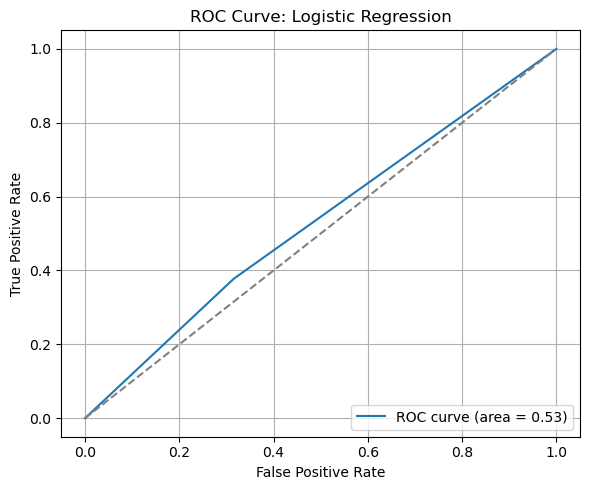

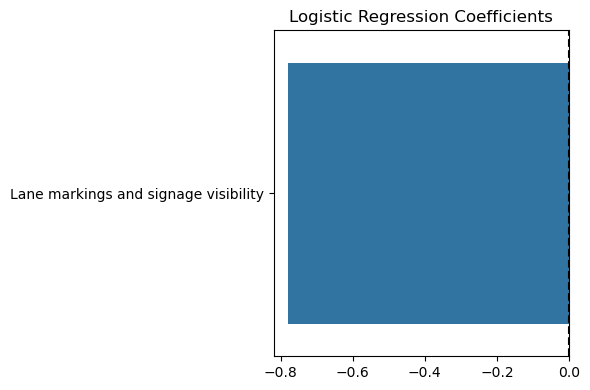

In [115]:
# Select features for modeling
selected_features = ["Lane markings and signage visibility"]

# Subset training and validation data
X_train_simple = X_train_resampled[selected_features].copy()
X_val_simple = X_val[selected_features].copy()

# Ordinal encode features (assumes integer-like categories)
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train_simple)
X_val_encoded = encoder.transform(X_val_simple)

# Train logistic regression
logreg1 = LogisticRegression(random_state=42)
logreg1.fit(X_train_encoded, y_train_resampled)

# Predict on validation set
y_val_pred = logreg1.predict(X_val_encoded)
y_val_probs = logreg1.predict_proba(X_val_encoded)[:, 1]

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize coefficients
feature_names = encoder.get_feature_names_out(selected_features)
coefs = logreg1.coef_[0]

plt.figure(figsize=(6, 4))
sns.barplot(x=coefs, y=feature_names)
plt.axvline(0, color="black", linestyle="--")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

##### Model 2: full predictive logistic regression model (logreg2)

We now retrain our logistic regression model on all the features

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.59      0.68       171
           1       0.22      0.44      0.30        45

    accuracy                           0.56       216
   macro avg       0.51      0.52      0.49       216
weighted avg       0.68      0.56      0.60       216

Confusion Matrix:
 [[101  70]
 [ 25  20]]


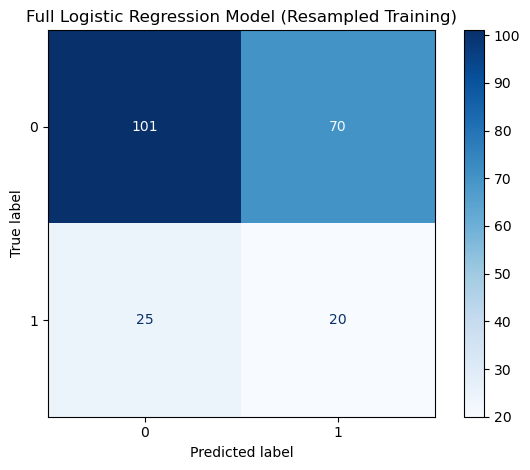

In [117]:
# 1. Preprocessing: One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), geo_features)
    ]
)

# 2. Logistic regression pipeline
logreg2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 3. Fit model
logreg2.fit(X_train_resampled, y_train_resampled)

# 4. Predict and evaluate
y_pred = logreg2.predict(X_val)

print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# 5. Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
disp.ax_.set_title("Full Logistic Regression Model (Resampled Training)")
plt.tight_layout()
plt.show()

We now find the best threshold for logreg2 using F1 score

Best threshold for F1: 0.440
Precision: 0.25, Recall: 0.84, F1: 0.39


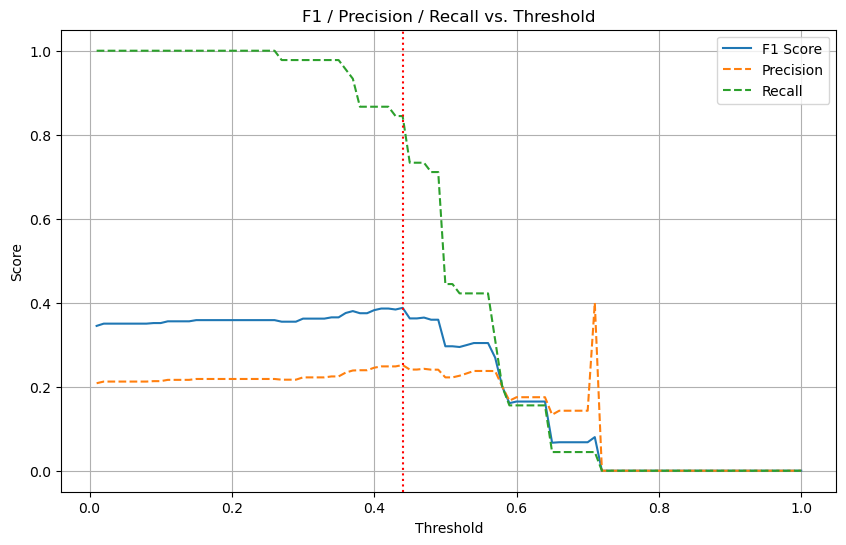

In [119]:
# get probabilities
y_probs = logreg2.predict_proba(X_val)[:, 1]

# Simulate thresholds from 0.01 to 1.0
thresholds = np.linspace(0.01, 1.0, 100)
f1_scores = []
precisions = []
recalls = []

# Compute F1, precision, and recall at each threshold
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"Precision: {precisions[best_index]:.2f}, Recall: {recalls[best_index]:.2f}, F1: {best_f1:.2f}")

# Optional: plot the scores
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.axvline(x=best_threshold, color='red', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 / Precision / Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

##### Model 3: CatBoost model (Catmodel)

Next, we train a model using CatBoost on our resampled dataset and perform some automatic hyperperameter selection using a gridsearch

In [121]:
# Step 1: Find Categorical Feature Indices
cat_indices = [X_train_resampled.columns.get_loc(col) for col in geo_features]


# Step 2: Initialize CatBoost
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    cat_features=cat_indices
)

# Step 3: Define grid search parameters
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3, 5]
}

# Step 4: GridSearchCV
grid = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Step 5: Fit on resampled training data
grid.fit(X_train_resampled, y_train_resampled)

# Best estimator becomes our final Catmodel
Catmodel = grid.best_estimator_

# Step 6: Predict on validation set
y_pred_val = Catmodel.predict(X_val)

# Step 7: Evaluation
print("Best Parameters:", grid.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

Confusion Matrix:
 [[ 62 109]
 [  8  37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.36      0.51       171
           1       0.25      0.82      0.39        45

    accuracy                           0.46       216
   macro avg       0.57      0.59      0.45       216
weighted avg       0.75      0.46      0.49       216



Now, we apply some threshold tuning for Catmodel

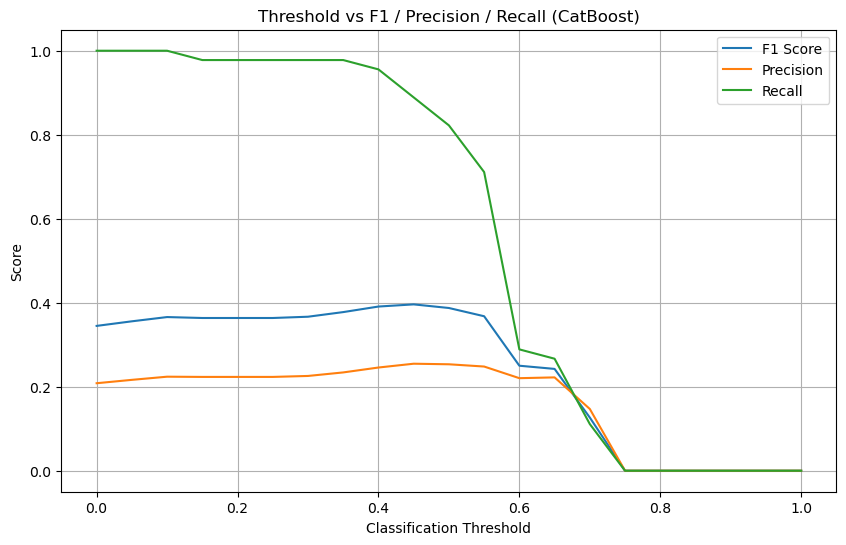

Best F1 threshold: 0.45
Precision: 0.25, Recall: 0.89, F1: 0.40


In [123]:
# Predict probabilities for the positive class (injurious)
y_probs = Catmodel.predict_proba(X_val)[:, 1]

# Range of thresholds to try
thresholds = np.arange(0.0, 1.05, 0.05)

f1_scores = []
precisions = []
recalls = []

# Silence precision warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Evaluate metrics for each threshold
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.title("Threshold vs F1 / Precision / Recall (CatBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Print best threshold
best_thresh_idx = np.argmax(f1_scores)
print(f"Best F1 threshold: {thresholds[best_thresh_idx]:.2f}")
print(f"Precision: {precisions[best_thresh_idx]:.2f}, Recall: {recalls[best_thresh_idx]:.2f}, F1: {f1_scores[best_thresh_idx]:.2f}")


#### 4. Intervention Testing

We now apply the safety intervention on our held out segment 8 crash data by first running our models on the data as-is, then we intervene by changing lane markings and signage visibility to "3" and comparing the results of our models. Note that we adjusted the prediction thresholds for the best F1-scores on our validation set.

In [132]:
# Create X_before and X_after using only geo_features
X_before = holdout_segment[geo_features].copy()
X_after = X_before.copy()

# Apply the intervention
X_after['Lane markings and signage visibility'] = "3"  # as string for CatBoost

# --- Logistic Regression (logreg2) ---
logreg_probs_before = logreg2.predict_proba(X_before)[:, 1]
logreg_probs_after = logreg2.predict_proba(X_after)[:, 1]
logreg_pred_before = (logreg_probs_before >= 0.440).astype(int)
logreg_pred_after = (logreg_probs_after >= 0.440).astype(int)

print("\n--- Logistic Regression ---")
print(f"Before Intervention Injurious Predictions: {logreg_pred_before.sum()}")
print(f"After Intervention Injurious Predictions:  {logreg_pred_after.sum()}")

# --- CatBoost (Catmodel) ---
cat_features = geo_features.copy()

# Convert ALL categorical features to string (CatBoost expects this)
for col in cat_features:
    X_before[col] = X_before[col].astype(str)
    X_after[col] = X_after[col].astype(str)

# Build CatBoost Pools
pool_before = Pool(X_before, cat_features=cat_features)
pool_after = Pool(X_after, cat_features=cat_features)

# Predict probabilities for positive class directly (already 1D arrays)
cat_probs_before = Catmodel.predict(pool_before, prediction_type="Probability")[:, 1]
cat_probs_after = Catmodel.predict(pool_after, prediction_type="Probability")[:, 1]

# Apply threshold
cat_pred_before = (cat_probs_before >= 0.45).astype(int)
cat_pred_after = (cat_probs_after >= 0.45).astype(int)

print("\n--- CatBoost ---")
print(f"Before Intervention Injurious Predictions: {cat_pred_before.sum()}")
print(f"After Intervention Injurious Predictions:  {cat_pred_after.sum()}")


--- Logistic Regression ---
Before Intervention Injurious Predictions: 71
After Intervention Injurious Predictions:  64

--- CatBoost ---
Before Intervention Injurious Predictions: 45
After Intervention Injurious Predictions:  51


The logistic regression model predicts a small decrease in number of injurious crashes after intervention, while our CatBoost model actually predicts an $\text{\emph{increase}}$ in number of injurious crashes after the intervention.

#### 5. Hypothesis Testing

Segment 8 had a total of 79 crashes, of which 22 were recorded as injurious. Our hypothesis test using bootstrap methods
evaluates whether the intervention would lead to a statistically significant reduction from this baseline.

$\textbf{Null hypothesis } H_{0}$: There is no change in the predicted rate of injurious crashes on the held-out segment after applying the intervention to lane markings and signage (i.e., the model predicts the same average injury rate).

$\textbf{Alternative hypothesis } H_{1}$: The intervention reduces the predicted injury rate.

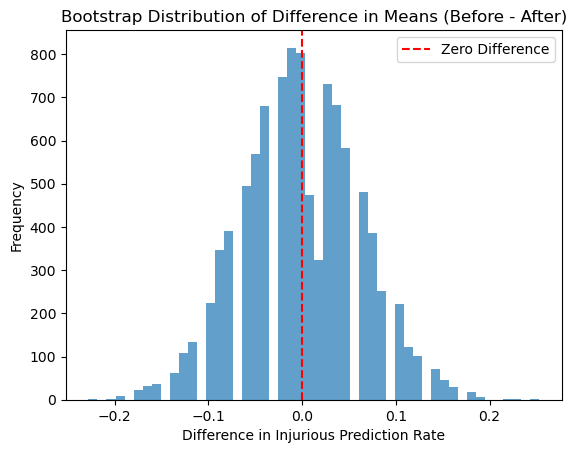

Logistic Regression:
Mean Before = 0.810 (95% CI: 0.722 – 0.899)
Mean After  = 0.810 (95% CI: 0.722 – 0.899)
p-value     = 0.5476



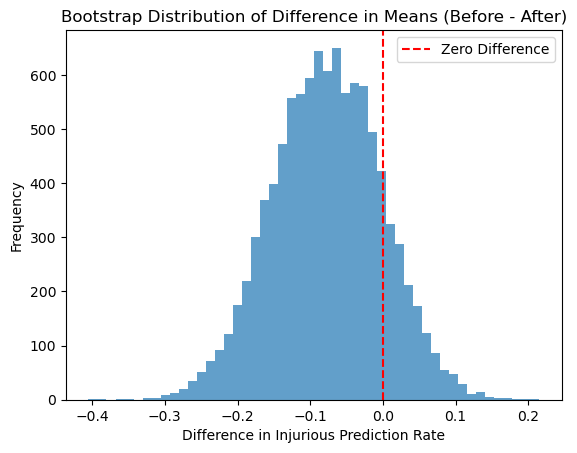

CatBoost:
Mean Before = 0.570 (95% CI: 0.468 – 0.671)
Mean After  = 0.646 (95% CI: 0.544 – 0.747)
p-value     = 0.8622


In [167]:
def bootstrap_hypothesis_test(before_preds, after_preds, n_bootstrap=10000, seed=42):
    np.random.seed(seed)

    before_means = []
    after_means = []

    for _ in range(n_bootstrap):
        before_sample = np.random.choice(before_preds, size=len(before_preds), replace=True)
        after_sample = np.random.choice(after_preds, size=len(after_preds), replace=True)

        before_means.append(before_sample.mean())
        after_means.append(after_sample.mean())

    before_means = np.array(before_means)
    after_means = np.array(after_means)

    diff_means = before_means - after_means

    # Compute p-value: proportion of bootstrap samples where after >= before
    p_value = np.mean(diff_means <= 0)

    # Confidence intervals (95%)
    ci_lower_before = np.percentile(before_means, 2.5)
    ci_upper_before = np.percentile(before_means, 97.5)

    ci_lower_after = np.percentile(after_means, 2.5)
    ci_upper_after = np.percentile(after_means, 97.5)

    # Plot for visualization
    plt.hist(diff_means, bins=50, alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Difference')
    plt.title("Bootstrap Distribution of Difference in Means (Before - After)")
    plt.xlabel("Difference in Injurious Prediction Rate")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return {
        "p_value": p_value,
        "mean_before": np.mean(before_preds),
        "mean_after": np.mean(after_preds),
        "ci_before": (ci_lower_before, ci_upper_before),
        "ci_after": (ci_lower_after, ci_upper_after)
    }

# Logistic Regression
logreg_probs_before = logreg2.predict_proba(X_before)[:, 1]
logreg_probs_after = logreg2.predict_proba(X_after)[:, 1]

# Use threshold (e.g. 0.44 from earlier tuning)
logreg_before = (logreg_probs_before >= 0.44).astype(int)
logreg_after = (logreg_probs_after >= 0.44).astype(int)
logreg_results = bootstrap_hypothesis_test(logreg_before, logreg_after)
print(f"Logistic Regression:")
print(f"Mean Before = {logreg_results['mean_before']:.3f} (95% CI: {logreg_results['ci_before'][0]:.3f} – {logreg_results['ci_before'][1]:.3f})")
print(f"Mean After  = {logreg_results['mean_after']:.3f} (95% CI: {logreg_results['ci_after'][0]:.3f} – {logreg_results['ci_after'][1]:.3f})")
print(f"p-value     = {logreg_results['p_value']:.4f}\n")

# CatBoost
cat_probs_before = Catmodel.predict(Pool(X_before, cat_features=cat_features), prediction_type="Probability")
cat_probs_after = Catmodel.predict(Pool(X_after, cat_features=cat_features), prediction_type="Probability")

# If output is shape (n_samples, 2), extract class 1 prob
if len(cat_probs_before.shape) == 2:
    cat_probs_before = cat_probs_before[:, 1]
    cat_probs_after = cat_probs_after[:, 1]

cat_before = (cat_probs_before >= 0.45).astype(int)
cat_after = (cat_probs_after >= 0.45).astype(int)
cat_results = bootstrap_hypothesis_test(cat_before, cat_after)
print(f"CatBoost:")
print(f"Mean Before = {cat_results['mean_before']:.3f} (95% CI: {cat_results['ci_before'][0]:.3f} – {cat_results['ci_before'][1]:.3f})")
print(f"Mean After  = {cat_results['mean_after']:.3f} (95% CI: {cat_results['ci_after'][0]:.3f} – {cat_results['ci_after'][1]:.3f})")
print(f"p-value     = {cat_results['p_value']:.4f}")


## Conclusion

We evaluated whether improving **lane markings and signage visibility** on the segment of highway I-40 from -88.373 to -88.286 would result in a **statistically significant reduction in injurious crashes**, using both a **logistic regression model** and a **CatBoost classifier** trained on geospatial features.

The logistic regression model predicted a small decrease in injurious crashes on our segment, however the difference was **not statistically significant** under bootstrap hypothesis testing.

### Key Takeaways
- **No strong evidence** was found to support the effectiveness of this intervention on the selected segment.
- **Confidence intervals** for the before and after predictions overlap substantially.
- Results may reflect the **limited sample size**, or that other factors (e.g., pavement condition or guardrails) may play a more influential role on this segment.

